# Practice with `freud`, `mdtraj` and `MDanalysis` Packages

Here is a short tutorial for the usage of [Freud](https://freud.readthedocs.io/en/stable), [mdtraj](https://mdtraj.org/), and [MD Analysis](https://docs.mdanalysis.org/1.0.0/index.html) packages, mainly for the use cases I'm interested in. These are Python packages that are extremely useful for analysis of GROMACS simulations (and other molecular dynamics software). They are easy to install from the Conda terminal with:

```
conda config --add channels conda-forge
conda update --all
conda install -c conda-forge freud
conda install -c conda-forge mdtraj
conda install mdanalysis
```

# `MDanalysis` package
First, import the packages, plus the `glob` package for testing purposes. We'll begin by looking at the MD Analysis library and looking at its capabilities

In [1]:
import MDAnalysis, freud, glob
import numpy as np
import array as arr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema

In [2]:
# user inputs
TimePerFrame = 1 # 10 ps per frame to check
Start_Points = arr.array('d',[29900]) # start points
End_Points = arr.array('d',[30000]) # end point
idx=0
Min_R = 0;
ref = 'Li'
sel = 'I'
Metal = 'Li'
Halide = 'I'

In [3]:
# Define your testing directory containing the results of a GROMACS simulation
testdir = 'C:\\Users\\Hayden\\Documents\\Patey_Lab\\Results\\LiI\\Step_W_JC_NPT\\'

# Use glob to grab your initial gro or pdb file (called a topology file by MD Analysis)
topology = glob.glob(testdir + '*.gro')[0]
trajectory = glob.glob(testdir + '*.trr')[0] # this can be a trr or xtc file

# Use the Universe method to creates a "universe" to contain your trajectory
t = MDAnalysis.Universe(topology, trajectory)

C:\ProgramData\Anaconda3\lib\site-packages\MDAnalysis\topology\guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: LI
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [4]:
t.select_atoms("name LI").indices

array([   0,    1,    4, ..., 5317, 5320, 5321], dtype=int64)

In [5]:
timestep = t.trajectory.dt # timestep in ps
steps_per_frame = int(TimePerFrame/timestep)

In [6]:
Mgroup = t.select_atoms('name Li').indices
Xgroup = t.select_atoms('name I').indices

In [7]:
min_time = t.trajectory[0].time # first time step in ps
max_time = t.trajectory[-1].time # last time step in ps

In [8]:
Start_Point = np.max([Start_Points[idx],min_time]) # ps
End_Point = np.min([End_Points[idx],max_time]) # ps

In [9]:
Start_Step = int(Start_Point/timestep) # index of the start point within trajectory
End_Step = int(End_Point/timestep) # index of the end point within trajectory
time_slice = list(range(Start_Step, End_Step+steps_per_frame, steps_per_frame))

In [10]:
def to_freud_box(dims):
    a = dims[0]/10
    b = dims[1]/10
    c = dims[2]/10
    alpha = np.deg2rad(dims[3])
    beta = np.deg2rad(dims[4])
    gamma = np.deg2rad(dims[5])

    Omega = a*b*c*np.sqrt(1 - (np.cos(alpha)**2) - (np.cos(beta)**2) - (np.cos(gamma)**2) + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma))
    cx = c*np.cos(beta)
    cy = c*(np.cos(alpha) - np.cos(beta)*np.cos(gamma))/np.sin(gamma)
    cz = Omega/(a*b*np.sin(gamma))

    Transform_Matrix = [[a,             b*np.cos(gamma),      cx],
                        [0,             b*np.sin(gamma),      cy],
                        [0,             0,                    cz]]
    
    return freud.box.Box.from_matrix(Transform_Matrix)

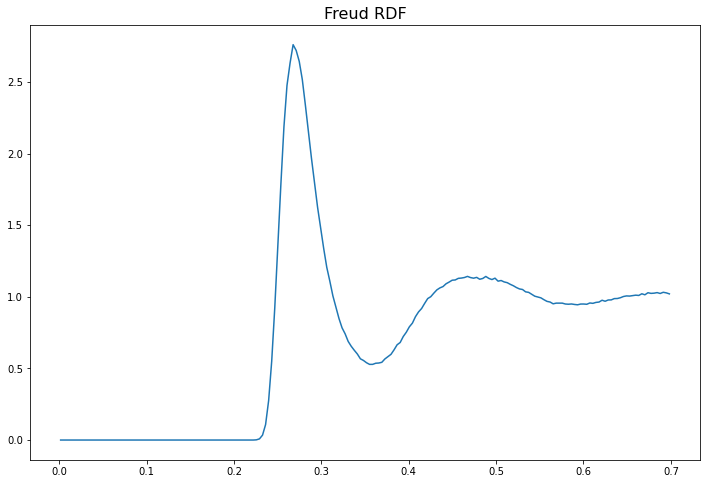

In [12]:
rdf = freud.density.RDF(200, 0.7)
for ts in t.trajectory[time_slice]:
    
    #print("Frame: {0:5d}, Time: {1:8.3f} ps".format(ts.frame, u.trajectory.time))
    box_data = to_freud_box(t.atoms.dimensions)
    pos_data = t.atoms.positions/10
    rdf.compute(system=(box_data, pos_data), reset=False)
    
rdf_x = rdf.bin_centers
rdf_y = getattr(rdf, 'rdf')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title('Freud RDF', fontsize=16)
ax.plot(rdf_x, rdf_y, label='RDF')

In [94]:
query_args = dict(mode='ball', r_min=0, r_max=0.345, exclude_ii=True)
Ql_result_TimeWindow = []
L_list = [2,4,6,8,10]
ref = 'Li'
sel = 'I'
for ts in t.trajectory[time_slice]:
    box_data = to_freud_box(t.atoms.dimensions)
    
    query_data = t.atoms.positions/10 # in nm
    if ref == Metal:
        query_data[t.select_atoms("name " + Halide).indices] = np.nan
    elif ref == Halide:
        query_data[t.select_atoms("name " + Metal).indices] = np.nan

    point_data = t.atoms.positions/10 # in nm
    if sel == Metal:
        point_data[t.select_atoms("name " + Halide).indices] = np.nan
    elif sel == Halide:
        point_data[t.select_atoms("name " + Metal).indices] = np.nan
    
    nlist = freud.locality.AABBQuery(box_data, point_data).query(query_data, query_args).toNeighborList()
    
    system = [box_data,t.atoms.positions/10] # in nm
    Ql_result = []
    for L_idx,L in enumerate(L_list):

        ql = freud.order.Steinhardt(L)
        ql_calc = ql.compute(system, neighbors=nlist)

        Ql_result.append(ql_calc.ql)

    Ql_result_TimeWindow.append(Ql_result)

In [96]:
Ql_result_TimeWindow

[[array([0.50250506, 0.4971732 ,        nan, ..., 0.49804145,        nan,
                nan], dtype=float32),
  array([0.38869458, 0.39335227,        nan, ..., 0.44217184,        nan,
                nan], dtype=float32),
  array([0.72089237, 0.7248564 ,        nan, ..., 0.66047955,        nan,
                nan], dtype=float32),
  array([0.5502479 , 0.54052925,        nan, ..., 0.5898071 ,        nan,
                nan], dtype=float32),
  array([0.48897156, 0.4910056 ,        nan, ..., 0.5478852 ,        nan,
                nan], dtype=float32)],
 [array([0.52937883, 0.56358355,        nan, ..., 0.4828897 ,        nan,
                nan], dtype=float32),
  array([0.57135737, 0.78808254,        nan, ..., 0.4566574 ,        nan,
                nan], dtype=float32),
  array([0.5407504 , 0.55472666,        nan, ..., 0.66275615,        nan,
                nan], dtype=float32),
  array([0.47066295, 0.6364019 ,        nan, ..., 0.5849884 ,        nan,
                nan], dtype=f

In [81]:
box_data = to_freud_box(t.atoms.dimensions)
pos_data = t.atoms.positions/10 # in nm

query_data = pos_data
if ref == Metal:
    query_data[t.select_atoms("name " + Halide).indices] = np.nan
elif ref == Halide:
    query_data[t.select_atoms("name " + Metal).indices] = np.nan

pos_data = t.atoms.positions/10 # in nm
if sel == Metal:
    pos_data[t.select_atoms("name " + Halide).indices] = np.nan
elif sel == Halide:
    pos_data[t.select_atoms("name " + Metal).indices] = np.nan
nlist = freud.locality.AABBQuery(box_data, pos_data).query(query_data, query_args).toNeighborList()
system = [box_data,pos_data]

In [83]:
ql = freud.order.Steinhardt(6)
ql_calc = ql.compute(system, neighbors=nlist)

In [86]:
pos_data

array([[       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [0.6569416 , 4.4750824 , 7.492133  ],
       ...,
       [       nan,        nan,        nan],
       [2.4688802 , 1.7305281 , 9.3772955 ],
       [2.012919  , 1.1519091 , 0.25193465]], dtype=float32)

In [71]:
ref = 'I'
sel = 'Li'
box_data = to_freud_box(t.atoms.dimensions)

query_data = t.atoms.positions/10 # in nm
if ref == Metal:
    query_data[t.select_atoms("name " + Halide).indices] = np.nan
elif ref == Halide:
    query_data[t.select_atoms("name " + Metal).indices] = np.nan

pos_data = t.atoms.positions/10 # in nm
if sel == Metal:
    pos_data[t.select_atoms("name " + Halide).indices] = np.nan
elif sel == Halide:
    pos_data[t.select_atoms("name " + Metal).indices] = np.nan

nlist = freud.locality.AABBQuery(box_data, pos_data).query(query_data, query_args).toNeighborList()

In [72]:
len(nlist)

7470

In [46]:
list1 = test.query_point_indices
list2 = t.select_atoms("name " + Metal).indices

In [49]:
list(find_matching_index(list1, list2))

[(0, 0), (1, 0), (2, 0), (3, 1), (4, 1), (5, 1), (6, 1)]

In [43]:
from itertools import groupby, product

def find_matching_index(list1, list2):
    sorted_list1 = sorted((element, index) for index, element in enumerate(list1))
    sorted_list2 = sorted((element, index) for index, element in enumerate(list2))

    list1_groups = groupby(sorted_list1, key=lambda pair: pair[0])
    list2_groups = groupby(sorted_list2, key=lambda pair: pair[0])

    for element1, group1 in list1_groups:
        try:
            element2, group2 = next(list2_groups)
            while element1 > element2:
                (element2, _), group2 = next(list2_groups)

        except StopIteration:
            break

        if element2 > element1:
            continue

        indices_product = product((i for _, i in group1), (i for _, i in group2), repeat=1)

        yield from indices_product

        # In version prior to 3.3, the above line must be
        # for x in indices_product:
        #     yield x

In [25]:
Ql_result_TimeWindow[0]

[array([0.50250506, 0.4971732 , 0.4665336 , ..., 0.49804145, 0.4987644 ,
        0.5260273 ], dtype=float32),
 array([0.38869458, 0.39335227, 0.7437574 , ..., 0.44217184, 0.45562416,
        0.7896274 ], dtype=float32),
 array([0.72089237, 0.7248564 , 0.46040484, ..., 0.66047955, 0.65327877,
        0.6696486 ], dtype=float32),
 array([0.5502479 , 0.54052925, 0.6351492 , ..., 0.5898071 , 0.5610934 ,
        0.7026457 ], dtype=float32),
 array([0.48897156, 0.4910056 , 0.53697693, ..., 0.5478852 , 0.6012521 ,
        0.74240613], dtype=float32)]

In [125]:
freud.box.Box.from_matrix(Transform_Matrix)

freud.box.Box(Lx=5.980443477630615, Ly=5.179215908050537, Lz=0.027959760278463364, xy=-0.5773491263389587, xz=-1.5137563423195388e-05, yz=-2.6219006031169556e-05, is2D=False)

In [126]:
box_data1

[freud.box.Box(Lx=5.9830522537231445, Ly=5.181475639343262, Lz=9.68688678741455, xy=-0.5773491263389587, xz=0.0, yz=0.0, is2D=False)]

In [14]:
for ts in u.trajectory[list(time_slice)]:
    time = u.trajectory.time
    pos = u.atoms.positions
    MDAnalysis.analysis.rdf.InterRDF_s(u, ags, nbins=75, range=(0.0, 1.0), density=False, **kwargs)
    print(time)

[[ 24.109861  16.467905  50.141663]
 [ 31.622145  35.063156  73.200195]
 [  8.413509  47.07795   73.69831 ]
 ...
 [-12.614388  32.464363   8.955413]
 [ 18.321766  17.983376   1.769746]
 [ 17.683746   9.003531  95.0759  ]]
[[18.313562  17.179104  53.55078  ]
 [29.93732   31.021767  72.94626  ]
 [ 6.569416  44.750824  74.92133  ]
 ...
 [45.67156   16.662615  12.522508 ]
 [24.6888    17.30528   93.77296  ]
 [20.129189  11.519091   2.5193465]]


In [15]:
? MDAnalysis.analysis.rdf.InterRDF_s

Object ` MDAnalysis.analysis.rdf.InterRDF_s` not found.


In [79]:
for t in time_slice:
    print(u.trajectory[t][0:10])

[[18.484808  15.178305  50.446854 ]
 [29.47482   32.140747  73.379585 ]
 [ 7.7312727 46.464844  75.27986  ]
 [22.408484  39.285313  83.13495  ]
 [15.310526  19.247868  55.195816 ]
 [ 8.726223  13.410156   8.362709 ]
 [ 5.742812  13.412851  73.780045 ]
 [ 9.824606  38.73055    3.7045982]
 [45.924576  18.853662  58.698963 ]
 [24.651297  50.751614  48.81277  ]]
[[18.313562  17.179104  53.55078  ]
 [29.93732   31.021767  72.94626  ]
 [ 6.569416  44.750824  74.92133  ]
 [24.496067  38.638317  82.48611  ]
 [19.161148  22.023293  53.006557 ]
 [ 8.148205  13.601327  12.609747 ]
 [ 4.327055  14.74031   75.07898  ]
 [ 9.159589  39.68947    3.9194245]
 [46.955482  17.486584  55.732178 ]
 [23.347586  50.075077  46.491894 ]]


In [45]:
test.trajectory[0]

< Timestep 0 with unit cell dimensions [ 50.075897  50.075874  81.0756    90.        90.       119.999954] >

# RDF with `mdtraj` and `Freud`

In [2]:
import mdtraj as md
import numpy as np
import freud
import glob
import matplotlib.pyplot as plt

In [3]:
testdir = 'C:\\Users\\Hayden\\Documents\\Patey_Lab\\Results\\LiI\\Step_W_JC_NPT\\'
topology = glob.glob(testdir + '*.gro')[0]
trajectory = glob.glob(testdir + '*.trr')[0] # this can be a trr or xtc file
t = md.load(trajectory, top=topology)

In [201]:
t[range(0,6,2)].time

array([0., 2., 4.], dtype=float32)

In [205]:
pairs = t[-1].top.select_pairs('all', 'all')
len(pairs)

14169826

In [224]:
rdf_x, rdf_y = md.geometry.rdf.compute_rdf(t[-1], pairs, periodic=True)

In [284]:
from scipy.ndimage import gaussian_filter1d
rdf_yp = gaussian_filter1d(rdf_y, 6)

In [289]:
from scipy.signal import argrelextrema
locmin = argrelextrema(rdf_yp, np.less) # local minima

In [290]:
smooth_d2 = np.gradient(np.gradient(rdf_yp))
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

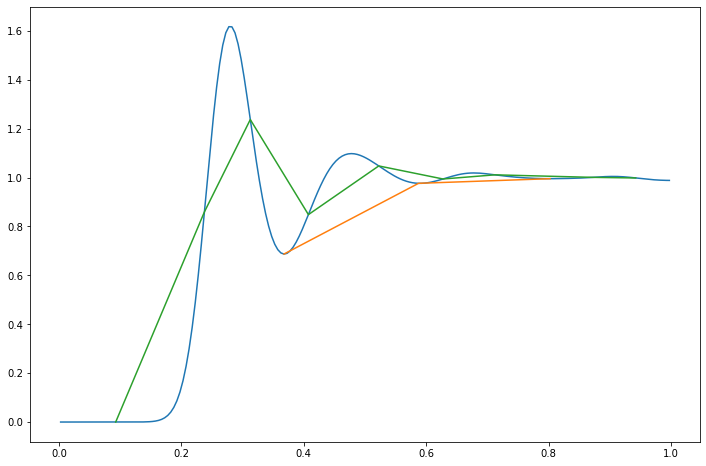

In [292]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(rdf_x, rdf_yp, label='rdf')
ax.plot(rdf_x[locmin[0]],rdf_yp[locmin[0]],label='locmin')
ax.plot(rdf_x[infls],rdf_yp[infls],label='locmin')

In [162]:
M_index = t.topology.select('element Li')
X_index = t.topology.select('element I')
All_pos = t.xyz
M_pos = t.xyz[M_index]
X_pos = t.xyz[X_index]

In [ ]:
nlist = freud.locality.AABBQuery(box_data_final, pos_data_final).query(pos_data_final, query_args).toNeighborList()

In [4]:
rdf_out = md.compute_rdf(t, pairs, r_range=None, bin_width=0.005, n_bins=None, periodic=True, opt=True)


NameError: name 'pairs' is not defined

## Speed test: RDF with `Freud` vs `mdtraj` for 1, 10, and 100 frames

In [121]:
# First load data and libraries
import mdtraj as md
import numpy as np
import freud
import glob
import matplotlib.pyplot as plt
import time

testdir = 'C:\\Users\\Hayden\\Documents\\Patey_Lab\\Results\\LiI\\Step_W_JC_NPT\\'
topology = glob.glob(testdir + '*.gro')[0]
trajectory = glob.glob(testdir + '*.trr')[0] # this can be a trr or xtc file
t = md.load(trajectory, top=topology)

In [4]:
list(range(29900,29901,1))

[29900]

mdtraj, 1 time slice: 1.8519984000004115 s
mdtraj, 10 time slice: 17.307453899999928 s
mdtraj, 10 time slice: 170.6337048000005 s


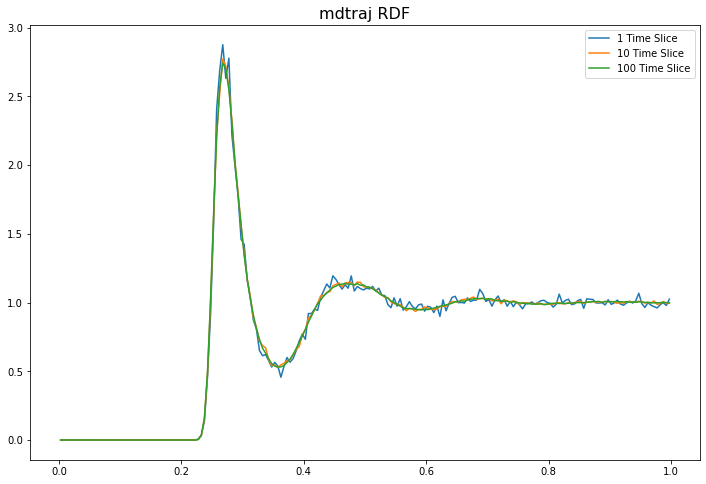

In [186]:
# Test 1: mdtraj
time_slice1 = list(range(29900,29901,1))
time_slice2 = list(range(29900,29910,1))
time_slice3 = list(range(29900,30000,1))
rrange = [0,1]
bins = 200

# test 1a: 1 time point
pairs = t[time_slice1].top.select_pairs('all', 'all')
start = time.perf_counter()
rdf1_x, rdf1_y = md.geometry.rdf.compute_rdf(t[time_slice1], pairs, periodic=True, r_range=rrange, n_bins=bins)
end = time.perf_counter()
print('mdtraj, 1 time slice: ' + str(end - start) + ' s')

# test 1b: 10 time point
pairs = t[time_slice2].top.select_pairs('all', 'all')
start = time.perf_counter()
rdf2_x, rdf2_y = md.geometry.rdf.compute_rdf(t[time_slice2], pairs, periodic=True, r_range=rrange, n_bins=bins)
end = time.perf_counter()
print('mdtraj, 10 time slice: ' + str(end - start) + ' s')

# test 1c: 100 time point
pairs = t[time_slice3].top.select_pairs('all', 'all')
start = time.perf_counter()
rdf3_x, rdf3_y = md.geometry.rdf.compute_rdf(t[time_slice3], pairs, periodic=True, r_range=rrange, n_bins=bins)
end = time.perf_counter()
print('mdtraj, 10 time slice: ' + str(end - start) + ' s')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title('mdtraj RDF', fontsize=16)
ax.plot(rdf1_x, rdf1_y, label='1 Time Slice')
ax.plot(rdf2_x, rdf2_y, label='10 Time Slice')
ax.plot(rdf3_x, rdf3_y, label='100 Time Slice')
ax.legend()

Freud, 1 time slice: 0.010613000000375905 s
Freud, 10 time slice: 0.09681490000002668 s
Freud, 100 time slice: 1.058733800000482 s


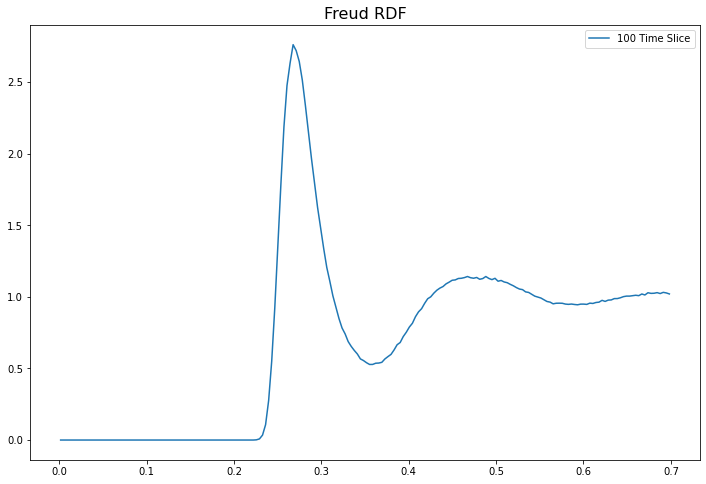

In [187]:
# Test 2: Freud
time_slice1 = list(range(29900,29901,1))
time_slice2 = list(range(29900,29910,1))
time_slice3 = list(range(29900,30000,1))
rrange = [0,1]
bins = 200

box_data1 = []
for cell_mat in t[time_slice1].unitcell_vectors:
    box_data1.append(freud.box.Box.from_matrix(cell_mat.transpose()))

# Grab position data from trajectory
pos_data1 = t[time_slice1].xyz

box_data2 = []
for cell_mat in t[time_slice2].unitcell_vectors:
    box_data2.append(freud.box.Box.from_matrix(cell_mat.transpose()))

# Grab position data from trajectory
pos_data2 = t[time_slice2].xyz

box_data3 = []
for cell_mat in t[time_slice3].unitcell_vectors:
    box_data3.append(freud.box.Box.from_matrix(cell_mat.transpose()))

# Grab position data from trajectory
pos_data3 = t[time_slice3].xyz

# Set up RDF
bins=200
r_max=0.7

start = time.perf_counter()
rdf1 = freud.density.RDF(bins, r_max)
for box, points in zip(box_data1, pos_data1):
    rdf1.compute(system=(box, points), reset=False)
end = time.perf_counter()
print('Freud, 1 time slice: ' + str(end - start) + ' s')

start = time.perf_counter()
rdf2 = freud.density.RDF(bins, r_max)
for box, points in zip(box_data2, pos_data2):
    rdf2.compute(system=(box, points), reset=False)
end = time.perf_counter()
print('Freud, 10 time slice: ' + str(end - start) + ' s')

start = time.perf_counter()
rdf3 = freud.density.RDF(bins, r_max)
for box, points in zip(box_data3, pos_data3):
    rdf3.compute(system=(box, points), reset=False)
end = time.perf_counter()
print('Freud, 100 time slice: ' + str(end - start) + ' s')


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title('Freud RDF', fontsize=16)
ax.plot(rdf1.bin_centers, getattr(rdf1, 'rdf'), label='1 Time Slice')
ax.plot(rdf2.bin_centers, getattr(rdf2, 'rdf'), label='10 Time Slice')
ax.plot(rdf3.bin_centers, getattr(rdf3, 'rdf'), label='100 Time Slice')
ax.legend()

In [208]:
u.atoms.dimensions

array([ 59.804436,  59.804405,  96.82663 ,  90.      ,  90.      ,
       119.999954], dtype=float32)

# RDF with `Freud`

In [ ]:
def plot_rdf(box_arr, points_arr, prop, r_max=1, bins=200, label=None, ax=None, title='rdf', newplot=False):
    """Helper function for plotting RDFs."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
    ax.set_title(title, fontsize=16)
    rdf = freud.density.RDF(bins, r_max)
    for box, points in zip(box_arr, points_arr):
        rdf.compute(system=(box, points), reset=newplot)
    if label is not None:
        ax.plot(rdf.bin_centers, getattr(rdf, prop), label=label)
        ax.legend()
    else:
        ax.plot(rdf.bin_centers, getattr(rdf, prop))
    return ax

In [4]:
# Convert each set of box vectors into a freud "box" object (one for each time point)
# Note that the transpose is required!
box_data = []
for cell_mat in t.unitcell_vectors:
    box_data.append(freud.box.Box.from_matrix(cell_mat.transpose()))

# Grab position data from trajectory
pos_data = t.xyz

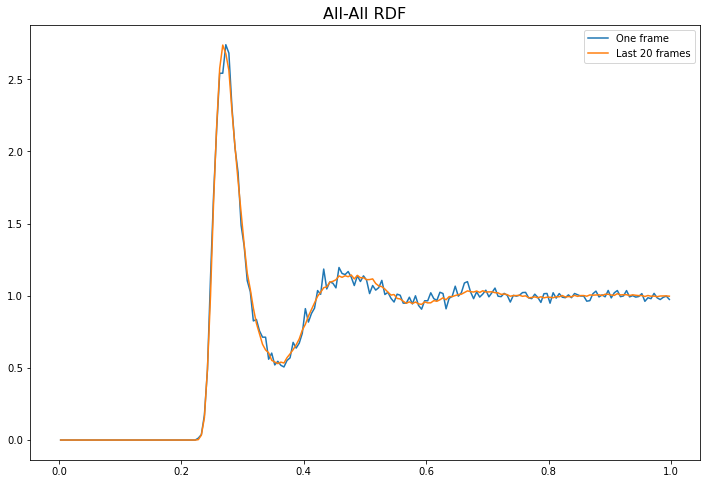

In [6]:
# Compute the All-All RDF for the last frame
box_arr = [box_data[-1]]
pos_arr = [pos_data[-1]]
ax = plot_rdf(box_arr, pos_arr, 'rdf', label='One frame')

# Compute the All-All RDF for the last 20 frames
box_arr = [box for box in box_data[-20:]]
pos_arr = pos_data[-20:]
ax = plot_rdf(box_arr, pos_arr, 'rdf', label='Last 20 frames', ax=ax, title='All-All RDF')

plt.show()

In [7]:
# Grab the separate element indexes
M_index = [atom.index for atom in t.topology.atoms if atom.element.symbol is 'Li']
X_index = [atom.index for atom in t.topology.atoms if atom.element.symbol is 'I']

In [8]:
# Separate out M and X at each time point
M_pos_data = []
for pos in pos_data:
    M_pos_data.append(pos[M_index])
    
X_pos_data = []
for pos in pos_data:
    X_pos_data.append(pos[X_index])

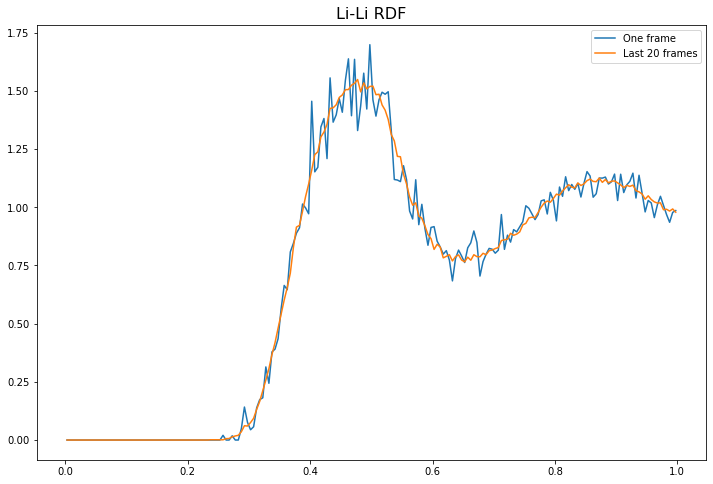

In [9]:
# Compute the Li-Li RDF for the last frame
box_arr = [box_data[-1]]
pos_arr = [M_pos_data[-1]]
ax = plot_rdf(box_arr, pos_arr, 'rdf', label='One frame', newplot=True)

# Compute the Li-Li RDF for the last 20 frames
box_arr = [box for box in box_data[-20:]]
pos_arr = M_pos_data[-20:]
ax = plot_rdf(box_arr, pos_arr, 'rdf', label='Last 20 frames', ax=ax, title='Li-Li RDF', newplot=False)

plt.show()

In [28]:
# Grab the separate element indexes
M_index = [atom.index for atom in t.topology.atoms if atom.element.symbol is 'Li']
X_index = [atom.index for atom in t.topology.atoms if atom.element.symbol is 'I']

M_Points = pos_data[-1][M_index]
X_points = pos_data[-1][X_index]
box = box_data[-1]

aq = freud.locality.AABBQuery(box, X_points)
query_result = aq.query(M_Points, dict(num_neighbors=4))

In [31]:
nlist = query_result.toNeighborList()

In [38]:
distances = []
for (i, j) in nlist:
    # Note that we have to wrap the bond vector before taking the norm;
    # this is the simplest way to compute distances in a periodic system.
    distances.append(np.linalg.norm(box.wrap(M_Points[i] - X_points[j])))

# Calculation of Ql/Wl Order Parameters with `Freud` and `mdtraj`

## 1. Import the trajectory and topology

In [1]:
import mdtraj as md
import numpy as np
import freud
import glob
import matplotlib.pyplot as plt

In [2]:
testdir = 'C:\\Users\\Hayden\\Documents\\Patey_Lab\\Results\\LiI\\Step_W_JC_NPT\\'
topology = glob.glob(testdir + '*.gro')[0]
trajectory = glob.glob(testdir + '*.trr')[0] # this can be a trr or xtc file
t = md.load(trajectory, top=topology)

## 2. Select out the M and X indices

In [3]:
# Grab the separate element indexes
M_index = [atom.index for atom in t.topology.atoms if atom.element.symbol is 'Li']
X_index = [atom.index for atom in t.topology.atoms if atom.element.symbol is 'I']

## 3. Create Box objects in `freud`

In [4]:
# Convert each set of box vectors into a freud "box" object (one for each time point)
# Note that the transpose is required!
box_data = []
for cell_mat in t.unitcell_vectors:
    box_data.append(freud.box.Box.from_matrix(cell_mat.transpose()))

# Grab position data from trajectory
pos_data = t.xyz

## 4. Select the time point of interest (final frame)

In [5]:
box_data_final = box_data[-1]
pos_data_final = pos_data[-1]
pos_data_final_M = pos_data_final[M_index]
pos_data_final_X = pos_data_final[X_index]

## 5. Create the appropriate neighbour list with `freud`

In [6]:
query_args = dict(mode='ball', r_min=0, r_max=0.3675, exclude_ii=True)
nlist = freud.locality.AABBQuery(box_data_final, pos_data_final).query(pos_data_final, query_args).toNeighborList()

## 5.1 Removing X from the query points of the neighbourlist
Use the code below to filer out all the X-X and X-M parts of the neighbour list

In [7]:
nlist.query_point_indices[0:50]

array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,
        4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  8,  8,  9,  9,  9, 10,
       10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 14, 14],
      dtype=uint32)

In [141]:
# Finding the indices of the neighbourlist that correspond to queries at X
X_query_indeces = [index for index, item in enumerate(nlist.query_point_indices) if item in set(X_index)]

# Convert the index list into a boolean list where True entries correspond to queries at M
# and False entries are queries at X
X_bonds_ind = np.array([True] * len(nlist.query_point_indices))
X_bonds_ind[X_query_indeces] = False

# Remove the queries at X from the list
nlist.filter(X_bonds_ind);

In [142]:
nlist.query_point_indices[0:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=uint32)

## 5.2 Removing M from the query points of the neighbourlist
Use the code below to filer out all the M-X and M-M parts of the neighbour list

In [125]:
nlist.query_point_indices[0:50]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  4,  4,  4,  4,
        4,  5,  5,  5,  8,  8,  8,  9,  9,  9, 12, 12, 12, 12, 13, 13, 13,
       16, 16, 16, 16, 17, 17, 17, 17, 20, 20, 20, 20, 20, 21, 21, 21],
      dtype=uint32)

In [126]:
# Finding the indices of the neighbourlist that correspond to queries at M
M_query_indeces = [index for index, item in enumerate(nlist.query_point_indices) if item in set(M_index)]

# Convert the index list into a boolean list where True entries correspond to queries at X
# and False entries are queries at M
M_bonds_ind = np.array([True] * len(nlist.query_point_indices))
M_bonds_ind[M_query_indeces] = False

# Remove the queries at X from the list
nlist.filter(M_bonds_ind);

In [127]:
nlist.query_point_indices[0:50]

array([], dtype=uint32)

## 5.3 Removing X from the system points of the neighbourlist
Use the code below to filer out all the X-X and M-X parts of the neighbour list

In [143]:
nlist.point_indices[0:50]

array([   4,  560, 1103, 1622, 1910, 2381, 2433, 3012, 3531, 4182, 4185,
       4956,   40, 1202, 2393, 2441, 3267, 3451, 3586, 4365,    0,  357,
       1544, 2084, 2381, 2862, 3382, 3531, 4043, 5138, 5151,  979, 1954,
       2114, 2627, 2836, 3929, 4918,  515, 2324, 2563, 2585, 2942, 4459,
       5087,  267,  273, 3906, 4161, 5230], dtype=uint32)

In [144]:
# Finding the indices of the neighbourlist that correspond to system points at X, queried from either M or X
X_point_indeces = [index for index, item in enumerate(nlist.point_indices) if item in set(X_index)]

# Convert the index list into a boolean list where True entries correspond to Any-M neighbours
# while False entries are Any-X neighbours
X_bonds_ind = np.array([True] * len(nlist.point_indices))
X_bonds_ind[X_point_indeces] = False

# Remove the queries at M from the list
nlist.filter(X_bonds_ind);

In [145]:
nlist.point_indices[0:50]

array([   4,  560, 2381, 2433, 3012, 4185, 4956,   40, 2393, 2441, 4365,
          0,  357, 1544, 2084, 2381, 2836, 3929, 2324, 2585,  273, 4161,
        712, 1676, 2252, 3492, 1549, 1633, 3409, 3909, 3445, 3605,  417,
       1196, 1277, 1513, 4368, 5068,  980, 3744, 4708, 1832, 3689, 4332,
       4708,  948, 2185, 3060, 2897, 3737], dtype=uint32)

## 5.4 Removing M from the system points of the neighbourlist
Use the code below to filer out all the X-M and M-M parts of the neighbour list

In [135]:
# Finding the indices of the remaining neighbourlist that correspond to points at M, queried from either M or X
M_point_indeces = [index for index, item in enumerate(nlist.point_indices) if item in set(M_index)]

# Convert the index list into a boolean list where True entries correspond to M-X neighbours, while False entries are M-M neighbours
# and False entries are M-M points
M_bonds_ind = np.array([True] * len(nlist.point_indices))
M_bonds_ind[M_point_indeces] = False

# Remove the queries at M from the list
nlist.filter(M_bonds_ind);

In [136]:
nlist.query_point_indices[0:50]

array([], dtype=uint32)

## 6. Package up the system for input into Ql

In [8]:
system = [box_data_final,pos_data_final]

In [9]:
system

[freud.box.Box(Lx=5.980443477630615, Ly=5.179215908050537, Lz=9.682662963867188, xy=-0.577349066734314, xz=0.0, yz=0.0, is2D=False),
 array([[1.8313562 , 1.7179104 , 5.355078  ],
        [2.993732  , 3.1021767 , 7.294626  ],
        [0.6569416 , 4.4750824 , 7.492133  ],
        ...,
        [4.567156  , 1.6662616 , 1.2522508 ],
        [2.4688802 , 1.730528  , 9.3772955 ],
        [2.012919  , 1.1519091 , 0.25193465]], dtype=float32)]

## 7. Calculate Q6

In [29]:
L=6
ql = freud.order.Steinhardt(L,wl=True)
ql_calc = ql.compute(system, neighbors=nlist)

# Remove nan values
#ql_nonan = ql_calc.ql[~np.isnan(ql_calc.ql)]

In [32]:
? freud.order.Steinhardt

Init signature:  freud.order.Steinhardt(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           c:\programdata\anaconda3\lib\site-packages\freud\order.cp37-win_amd64.pyd
Type:           type
Subclasses:     


In [30]:
ql_calc.particle_order

array([-0.00847488, -0.00046329, -0.00721052, ..., -0.00644202,
       -0.00390487, -0.00272534], dtype=float32)

In [31]:
ql_calc.ql

array([0.40490454, 0.43404028, 0.5006246 , ..., 0.54726386, 0.55169815,
       0.3630224 ], dtype=float32)

In [314]:
ql_nonan[-100:]

array([0.5219497 , 0.61927897, 0.569363  , 0.6049225 , 0.438755  ,
       0.67251843, 0.41827723, 0.5412601 , 0.61672467, 0.7434085 ,
       0.55622584, 0.6237628 , 0.5716162 , 0.5198577 , 0.48747045,
       0.48450896, 0.6659806 , 0.81606823, 0.5090423 , 0.5054983 ,
       0.607464  , 0.5042969 , 0.7203739 , 0.6946058 , 0.55012846,
       0.52193177, 0.650923  , 0.6775302 , 0.42079973, 0.602232  ,
       0.51553386, 0.6131919 , 0.6240244 , 0.4903371 , 0.41499275,
       0.50747186, 0.502792  , 0.47341317, 0.57099813, 0.64663386,
       0.51604587, 0.50387204, 0.40660834, 0.5414179 , 0.6220946 ,
       0.5418899 , 0.6495887 , 0.37187594, 0.71943086, 0.5404406 ,
       0.4110766 , 0.57178396, 0.4997354 , 0.70617694, 0.49919245,
       0.48818016, 0.7411104 , 0.5332245 , 0.5410372 , 0.59831417,
       0.47652894, 0.5090048 , 0.87504923, 0.6460537 , 0.43419984,
       0.67114854, 0.65943366, 0.58846146, 0.52600163, 0.48755807,
       0.63614345, 0.71523243, 0.66740024, 0.8003497 , 0.53946

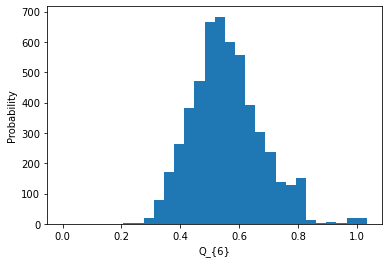

In [315]:
#weights = np.ones_like(ql_nonan)/float(len(ql_nonan))
bin_edges = np.r_[np.linspace(0, 1, num=30),np.linspace(0, 1, num=30)[1]+1]
n,x,h = plt.hist(ql_nonan, density=False, bins=bin_edges)  # `density=False` would make counts
#n,x = np.histogram(ql_nonan,bins=30)
#bin_centers = 0.5*(x[1:]+x[:-1])
#plt.plot(bin_centers,n)
plt.ylabel('Probability')
plt.xlabel('Q_{6}');